# (1)  Data exploration

### Import all the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from pycaret import classification
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


### Loading the dataset

In [3]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Assume Name and PassengerId do not affect the results and remove them
#df.drop(["Name", "PassengerId"], axis=1, inplace=True)
#test_df.drop(["Name", "PassengerId"], axis=1, inplace=True)

### Check the basic information about data

##### Training data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
#preview the data
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


##### Testing data

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [7]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


The above result showing that:

(1) Testing data do not have the features "Transported".

(2) Categorical features are "Name", "PassengerId", "HomePlanet", "CryoSleep", "Cabin",  "Destination" and "VIP".

### Create the functions for data cleaning and data transformation

In [8]:
def show_table(encoder):
  length=len(encoder.classes_)
  key=list(encoder.inverse_transform(np.arange(len(encoder.classes_))))
  value=np.arange(length)
  dic=dict(zip(key,value))
  print(dic)

def clean_cabin(x):
#Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  try:
    li=x['Cabin'].split('/')
    d=li[0]
    n=li[1]
    s=li[2]
    return [d,n,s]
  except:
    return [0,0,0]

def cleaner(coder_li,col_li,indf):
  for i in range(len(coder_li)):
    try:
      target=col_li[i]
      coder_li[i].fit(indf[target])
      indf[target]=coder_li[i].transform(indf[target])
      print(target,' coder dic:')
      show_table(coder_li[i])
    except Exception as e:
      print(target)
      print(e)
      break
  return indf

def handle_null(df):
  for i in df.columns:
    if i not in "Age":
      df[i].fillna(df[i].mode()[0], inplace=True)
    else:
      df["Age"].fillna(df["Age"].median(), inplace=True)
  return df

def clean_age(x):
  a = x['Age']
  if a <12:
    return 'Age 0-11'
  elif a>=12 and a<18:
    return 'Age 12-17'
  elif a>=18 and a<25:
    return 'Age 18-24'
  elif a>=25 and a<30:
    return 'Age 25-29'
  elif a>=30 and a<50:
    return 'Age 30-49'
  else:
    return 'Age 50+'

def clean_spend_gp(x):
  spent = x['total_spend']
  if spent == 0:
    return 'no spend'
  else:
    return 'spent'

def clean_pp(x):
  code = x['PassengerId']
  no = code.split('_')[1]
  group = code.split('_')[0]
  return int(no),int(group)

def clean_name(name):
  return name.split(' ')[1]

## Data Cleaning

##### Missing value in training data

In [9]:
missing = df.isna().sum()
print(missing)

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


##### Missing value in testing data

In [10]:
missing = test_df.isna().sum()
print(missing)

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


The above result show that only the attributes "Transported" did not contain any missing values.

##### Visualizing missing data

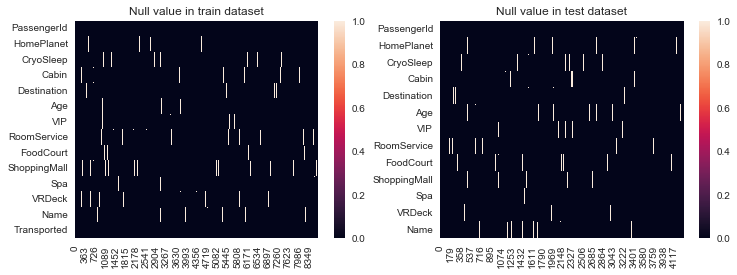

In [11]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.heatmap(df.isna().transpose(), ax=ax[0])
ax[0].set_title('Null value in train dataset')

sns.heatmap(test_df.isna().transpose(), ax=ax[1])
ax[1].set_title('Null value in test dataset')

plt.show()

##### Handing the null data

**Different methods of handling  null value will cause difference results, we decided to try difference  ways of null value handle to obtain the best results**

##### (First tiral)
We will fill the age with median value and others features with mode value 

In [12]:
#Training data
df_Ft = handle_null(df.copy())

#Check the infomation of new dataframe
df_Ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(3), float64(6), object(5)
memory usage: 772.6+ KB


In [13]:
#Testing data
test_df_Ft = handle_null(test_df.copy())

#Check the infomation of new dataframe
test_df_Ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   object 
 2   CryoSleep     4277 non-null   bool   
 3   Cabin         4277 non-null   object 
 4   Destination   4277 non-null   object 
 5   Age           4277 non-null   float64
 6   VIP           4277 non-null   bool   
 7   RoomService   4277 non-null   float64
 8   FoodCourt     4277 non-null   float64
 9   ShoppingMall  4277 non-null   float64
 10  Spa           4277 non-null   float64
 11  VRDeck        4277 non-null   float64
 12  Name          4277 non-null   object 
dtypes: bool(2), float64(6), object(5)
memory usage: 376.0+ KB


##### (Second tiral)
We will drop all the null value 

In [14]:
#Training data
df_St = df.copy().dropna()

#Check the infomation of new dataframe
df_St.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 729.0+ KB


In [15]:
#Testing data
test_df_St = test_df.copy().dropna()

#Check the infomation of new dataframe
test_df_St.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3281 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   3281 non-null   object 
 1   HomePlanet    3281 non-null   object 
 2   CryoSleep     3281 non-null   object 
 3   Cabin         3281 non-null   object 
 4   Destination   3281 non-null   object 
 5   Age           3281 non-null   float64
 6   VIP           3281 non-null   object 
 7   RoomService   3281 non-null   float64
 8   FoodCourt     3281 non-null   float64
 9   ShoppingMall  3281 non-null   float64
 10  Spa           3281 non-null   float64
 11  VRDeck        3281 non-null   float64
 12  Name          3281 non-null   object 
dtypes: float64(6), object(7)
memory usage: 358.9+ KB


## Feature engineering

#### Handling the feature "Cabin"

 (split feature "Cabin" to 3 features and format data)

In [16]:
#Training data (First tiral data)

df_Ft[["deck","num","side"]]=df_Ft.apply(clean_cabin, axis=1, result_type="expand")
df_Ft=df_Ft.drop('Cabin',axis=1)
df_Ft = df_Ft.astype({'deck':'str','side':'str','CryoSleep':'str','VIP':'str','num':'int'})

print("####################### First tiral training data #######################")
print(df_Ft.head(3))

#Training data (Second tiral data)
df_St[["deck","num","side"]]=df_St.apply(clean_cabin, axis=1, result_type="expand")
df_St=df_St.drop('Cabin',axis=1)
df_St = df_St.astype({'deck':'str','side':'str','CryoSleep':'str','VIP':'str','num':'int'})
print("####################### Second tiral training data #######################")
print(df_St.head(3))

####################### First tiral training data #######################
  PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01     Europa     False  TRAPPIST-1e  39.0  False          0.0   
1     0002_01      Earth     False  TRAPPIST-1e  24.0  False        109.0   
2     0003_01     Europa     False  TRAPPIST-1e  58.0   True         43.0   

   FoodCourt  ShoppingMall     Spa  VRDeck             Name  Transported deck  \
0        0.0           0.0     0.0     0.0  Maham Ofracculy        False    B   
1        9.0          25.0   549.0    44.0     Juanna Vines         True    F   
2     3576.0           0.0  6715.0    49.0    Altark Susent        False    A   

   num side  
0    0    P  
1    0    S  
2    0    S  
####################### Second tiral training data #######################
  PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01     Europa     False  TRAPPIST-1e  39.0  False          0.0   
1     0

In [17]:
#Testing data (First tiral data)

test_df_Ft[["deck","num","side"]]= test_df_Ft.apply(clean_cabin, axis=1, result_type="expand")
test_df_Ft = test_df_Ft.drop('Cabin',axis=1)
test_df_Ft = test_df_Ft.astype({'deck':'str','side':'str','CryoSleep':'str','VIP':'str','num':'int'})

print("####################### First tiral testing data #######################")
print(test_df_Ft.head(3))

#Testing data (Second tiral data)
test_df_St[["deck","num","side"]]= test_df_St.apply(clean_cabin, axis=1, result_type="expand")
test_df_St = test_df_St.drop('Cabin',axis=1)
test_df_St = test_df_St.astype({'deck':'str','side':'str','CryoSleep':'str','VIP':'str','num':'int'})
print("####################### Second tiral testing data #######################")
print(test_df_St.head(3))

####################### First tiral testing data #######################
  PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0     0013_01      Earth      True  TRAPPIST-1e  27.0  False          0.0   
1     0018_01      Earth     False  TRAPPIST-1e  19.0  False          0.0   
2     0019_01     Europa      True  55 Cancri e  31.0  False          0.0   

   FoodCourt  ShoppingMall     Spa  VRDeck             Name deck  num side  
0        0.0           0.0     0.0     0.0  Nelly Carsoning    G    3    S  
1        9.0           0.0  2823.0     0.0   Lerome Peckers    F    4    S  
2        0.0           0.0     0.0     0.0  Sabih Unhearfus    C    0    S  
####################### Second tiral testing data #######################
  PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0     0013_01      Earth      True  TRAPPIST-1e  27.0  False          0.0   
1     0018_01      Earth     False  TRAPPIST-1e  19.0  False          0.0   
2    

#### Handling features "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"

(Create a new attribute "TotalSpent" using mentioned features)

In [18]:
#Training data
df_Ft['total_spend'] = df_Ft[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply(lambda x: sum(x),axis=1)
df_St['total_spend'] = df_St[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply(lambda x: sum(x),axis=1)

#Testing data
test_df_Ft['total_spend'] = test_df_Ft[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply(lambda x: sum(x),axis=1)
test_df_St['total_spend'] = test_df_St[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].apply(lambda x: sum(x),axis=1)

(Check the distribution of total_spend and the relation with target "Transported")

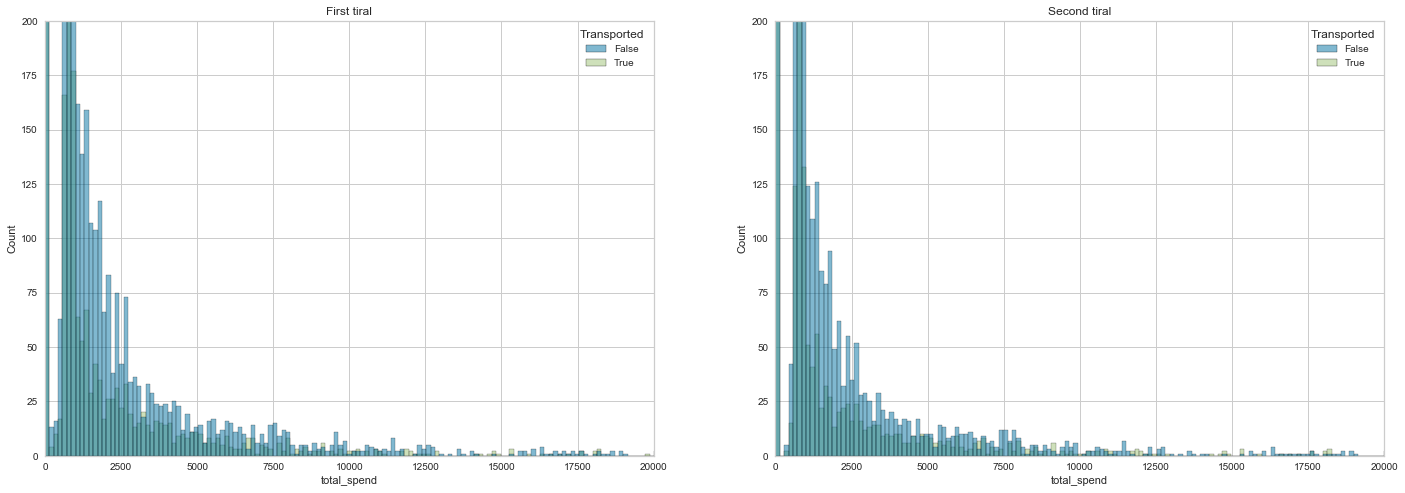

In [19]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

sns.histplot(data=df_Ft, x='total_spend', hue='Transported', bins=250, ax=ax[0])
ax[0].set_title('First tiral')

ax[0].set_xlim([0, 20000])
ax[0].set_ylim([0, 200])

sns.histplot(data=df_St, x='total_spend', hue='Transported', bins=250, ax=ax[1])
ax[1].set_title('Second tiral')
ax[1].set_xlim([0, 20000])
ax[1].set_ylim([0, 200])


plt.show()

#### Handling the feature "total_spent"

From the feature "total_spent", we can know who spent money or not in the spaceship

In [20]:
#Trianing data
df_Ft['spending'] = df_Ft.apply(clean_spend_gp,axis=1,result_type="expand")
df_St["spending"] = df_St.apply(clean_spend_gp,axis=1,result_type="expand")

#Testing data
test_df_Ft["spending"] = test_df_Ft.apply(clean_spend_gp, axis=1, result_type="expand")
test_df_Ft["spending"] = test_df_Ft.apply(clean_spend_gp, axis=1, result_type="expand")

#### Handling the feature "PassengerId"


Each Id has the following format: gggg pp, where pp is the passenger's position inside the group and gggg denotes the group they are traveling with.

Usually, but not always, family members make up a group of people.


In [21]:
#Trianing data
df_Ft["p_num"] = df_Ft.apply(clean_pp, axis=1, result_type="expand")[0]
df_Ft["gp_num"] = df_Ft.apply(clean_pp, axis=1, result_type="expand")[1]

df_St["p_num"] = df_St.apply(clean_pp, axis=1, result_type="expand")[0]
df_St["gp_num"] = df_St.apply(clean_pp, axis=1, result_type="expand")[1]

#Testing data
test_df_Ft["p_num"] = test_df_Ft.apply(clean_pp, axis=1, result_type="expand")[0]
test_df_Ft["gp_num"] = test_df_Ft.apply(clean_pp, axis=1, result_type="expand")[1]

test_df_St["p_num"] = test_df_St.apply(clean_pp, axis=1, result_type="expand")[0]
test_df_St["gp_num"] = test_df_St.apply(clean_pp, axis=1, result_type="expand")[1]

#### Handling the feature "Name"

People with the same last name may related

In [22]:
#Trianing data
df_Ft["last_name"] = df_Ft["Name"].apply(lambda name: clean_name(name))
df_St["last_name"] = df_St["Name"].apply(lambda name: clean_name(name))

#Testing data
test_df_Ft["last_name"] = test_df_Ft["Name"].apply(lambda name: clean_name(name))
test_df_St["gp_num"] = test_df_St["Name"].apply(lambda name: clean_name(name))

#### Deplay the new dataframe in different tirals

In [23]:
#Display first
df_Ft.head(3)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,total_spend,spending,p_num,gp_num,last_name
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0.0,no spend,1,1,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,736.0,spent,1,2,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,10383.0,spent,1,3,Susent


In [24]:
#Display second tiral data
df_St.head(3)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,total_spend,spending,p_num,gp_num,last_name
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0.0,no spend,1,1,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,736.0,spent,1,2,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,10383.0,spent,1,3,Susent


#### Droping features

we assume that "Name" and "PassengerId" do not affect the results and hence remove them

In [25]:
#Trianing data
df_Ft.drop(["Name", "PassengerId"], axis=1, inplace=True)
df_St.drop(["Name", "PassengerId"], axis=1, inplace=True)

#Testing data
test_df_Ft.drop(["Name", "PassengerId"], axis=1, inplace=True)
test_df_St.drop(["Name", "PassengerId"], axis=1, inplace=True)

#### Viewing the lastest dataframe

Since the struscture of testing data are very close to the training data, we are only interested on the lastest dataframe of the training data only

(first tiral)

In [26]:
df_Ft.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,total_spend,spending,p_num,gp_num,last_name
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,0.0,no spend,1,1,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,736.0,spent,1,2,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,10383.0,spent,1,3,Susent


In [27]:
df_Ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   object 
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  deck          8693 non-null   object 
 12  num           8693 non-null   int32  
 13  side          8693 non-null   object 
 14  total_spend   8693 non-null   float64
 15  spending      8693 non-null   object 
 16  p_num         8693 non-null   int64  
 17  gp_num        8693 non-null   int64  
 18  last_name     8693 non-null 

(Second tiral)

In [28]:
df_St.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,total_spend,spending,p_num,gp_num,last_name
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,0.0,no spend,1,1,Ofracculy
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,736.0,spent,1,2,Vines
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,10383.0,spent,1,3,Susent


In [29]:
df_St.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    6606 non-null   object 
 1   CryoSleep     6606 non-null   object 
 2   Destination   6606 non-null   object 
 3   Age           6606 non-null   float64
 4   VIP           6606 non-null   object 
 5   RoomService   6606 non-null   float64
 6   FoodCourt     6606 non-null   float64
 7   ShoppingMall  6606 non-null   float64
 8   Spa           6606 non-null   float64
 9   VRDeck        6606 non-null   float64
 10  Transported   6606 non-null   bool   
 11  deck          6606 non-null   object 
 12  num           6606 non-null   int32  
 13  side          6606 non-null   object 
 14  total_spend   6606 non-null   float64
 15  spending      6606 non-null   object 
 16  p_num         6606 non-null   int64  
 17  gp_num        6606 non-null   int64  
 18  last_name     6606 non-null 

## Data Transformation

#### Encode the data (Convert categorical data to numerical data)

In [30]:
from sklearn import preprocessing

#Create the encoder
HomePlanetEncoder = preprocessing.LabelEncoder()
CryoSleepEncoder = preprocessing.LabelEncoder()
DestinationEncoder = preprocessing.LabelEncoder()
VIPEncoder = preprocessing.LabelEncoder()
TransportedEncoder = preprocessing.LabelEncoder()
deckEncoder = preprocessing.LabelEncoder()
sideEncoder = preprocessing.LabelEncoder()
spendingEncoder = preprocessing.LabelEncoder()
last_nameEncoder = preprocessing.LabelEncoder()


coder_li = [HomePlanetEncoder,CryoSleepEncoder,DestinationEncoder,VIPEncoder,TransportedEncoder,deckEncoder,sideEncoder,spendingEncoder,last_nameEncoder]
col_li = ['HomePlanet','CryoSleep','Destination','VIP','Transported','deck','side','spending','last_name']

#Training data
cleaned_df_Ft = cleaner(coder_li,col_li,df_Ft) #First tiral
cleaned_df_St = cleaner(coder_li,col_li,df_St) #Second tiral

#Testing data
cleaned_test_df_Ft = cleaner(coder_li,col_li,test_df_Ft) #First tiral
cleaned_test_df_Ft = cleaner(coder_li,col_li,test_df_St) #Second tiral

HomePlanet  coder dic:
{'Earth': 0, 'Europa': 1, 'Mars': 2}
CryoSleep  coder dic:
{'False': 0, 'True': 1}
Destination  coder dic:
{'55 Cancri e': 0, 'PSO J318.5-22': 1, 'TRAPPIST-1e': 2}
VIP  coder dic:
{'False': 0, 'True': 1}
Transported  coder dic:
{False: 0, True: 1}
deck  coder dic:
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}
side  coder dic:
{'P': 0, 'S': 1}
spending  coder dic:
{'no spend': 0, 'spent': 1}
last_name  coder dic:
{'Acobson': 0, 'Acobsond': 1, 'Adavisons': 2, 'Adkinson': 3, 'Admingried': 4, 'Ageurante': 5, 'Aginge': 6, 'Ailled': 7, 'Aillyber': 8, 'Aiming': 9, 'Ainatint': 10, 'Aindlylid': 11, 'Ainserfle': 12, 'Airdring': 13, 'Aivering': 14, 'Alaring': 15, 'Alaxed': 16, 'Alberts': 17, 'Alcemblery': 18, 'Alenat': 19, 'Alenter': 20, 'Alentonway': 21, 'Alest': 22, 'Alfordonard': 23, 'Alindiveng': 24, 'Alldson': 25, 'Aloubtled': 26, 'Alshipson': 27, 'Alvasquez': 28, 'Alvercal': 29, 'Alvesssidy': 30, 'Ambleetive': 31, 'Ambleeve': 32, 'Amblereld': 33, 'A

## Final data preprocessing

Difference features selection will create different model and the results are greatlt impacted.

In this stage, we are going to choose different features as well as the best data scaling method to form the model

**As the testing data is used for evaluate the model performance, we will only use the training data for the final data preprocessing** 

In [31]:
#First Trial
X_Ft = cleaned_df_Ft.drop("Transported",axis = 1)
col_names = list(X_Ft.columns)
y_Ft = cleaned_df_Ft['Transported']

#Second Trial
X_St = cleaned_df_St.drop("Transported",axis = 1)
col_names = list(X_St.columns)
y_St = cleaned_df_St['Transported']

#### Data Visualization

Check data distribution(is balance, any outlier, correlation etc.)

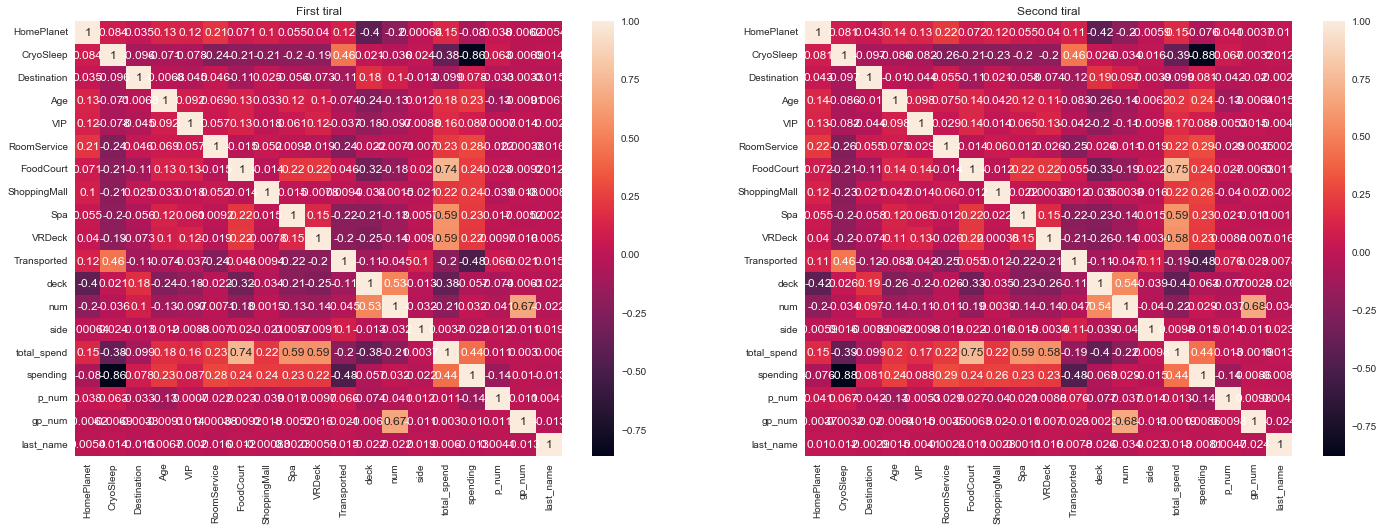

In [32]:
#Find the correlation between features by heatmap
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

ax[0].set_title('First tiral')
sns.heatmap(cleaned_df_Ft.corr(),annot=True, ax = ax[0])

sns.heatmap(cleaned_df_St.corr(),annot=True, ax = ax[1])
ax[1].set_title('Second tiral')
plt.show()

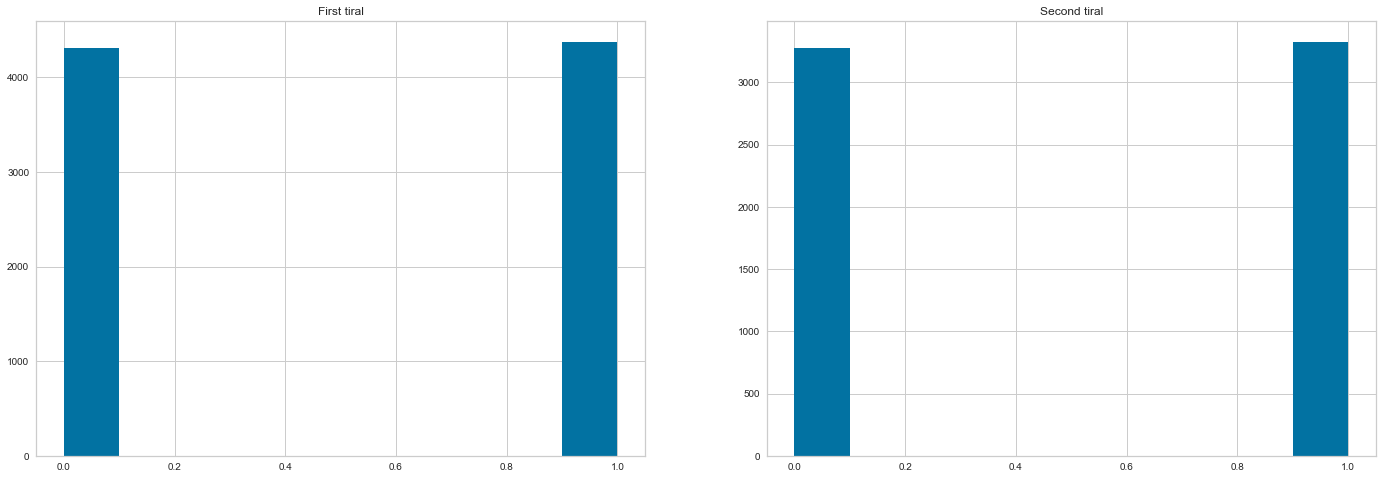

In [33]:
#Check the distirbution of the target feature 
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

y_Ft.hist(ax = ax[0])
ax[0].set_title('First tiral')

y_St.hist(ax = ax[1])
ax[1].set_title('Second tiral')
plt.show()

In [34]:
X_Ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int32  
 1   CryoSleep     8693 non-null   int32  
 2   Destination   8693 non-null   int32  
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   int32  
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  deck          8693 non-null   int32  
 11  num           8693 non-null   int32  
 12  side          8693 non-null   int32  
 13  total_spend   8693 non-null   float64
 14  spending      8693 non-null   int32  
 15  p_num         8693 non-null   int64  
 16  gp_num        8693 non-null   int64  
 17  last_name     8693 non-null   int32  
dtypes: float64(7), int32(9), int

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E897C4B508>,
      dtype=object)

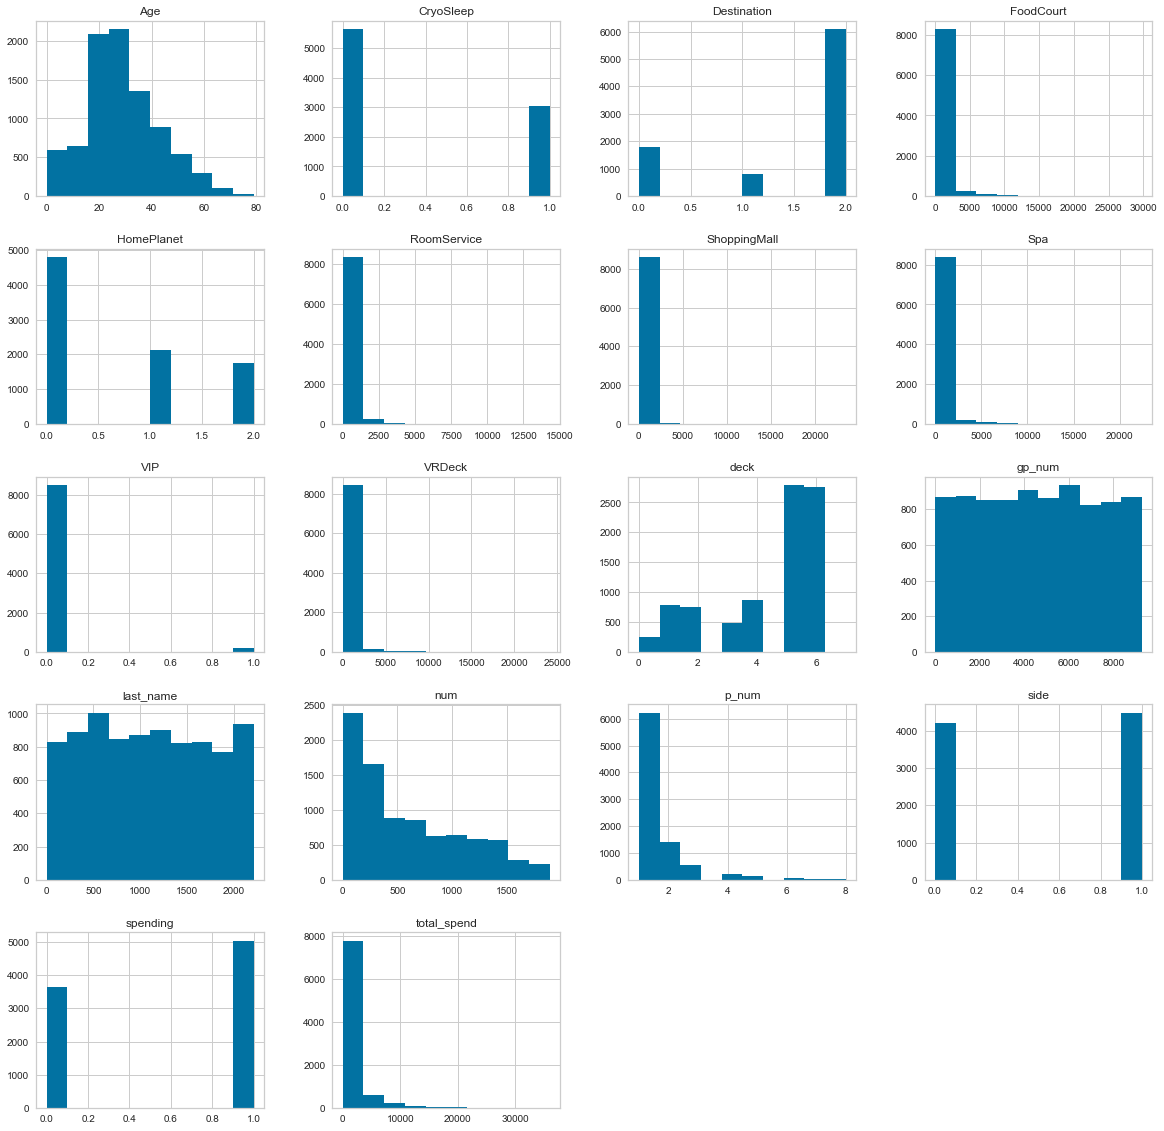

In [35]:
#Check the distirbution of the features 
X_Ft.hist(figsize=(20,20))#First tiral

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E89733A848>,
      dtype=object)

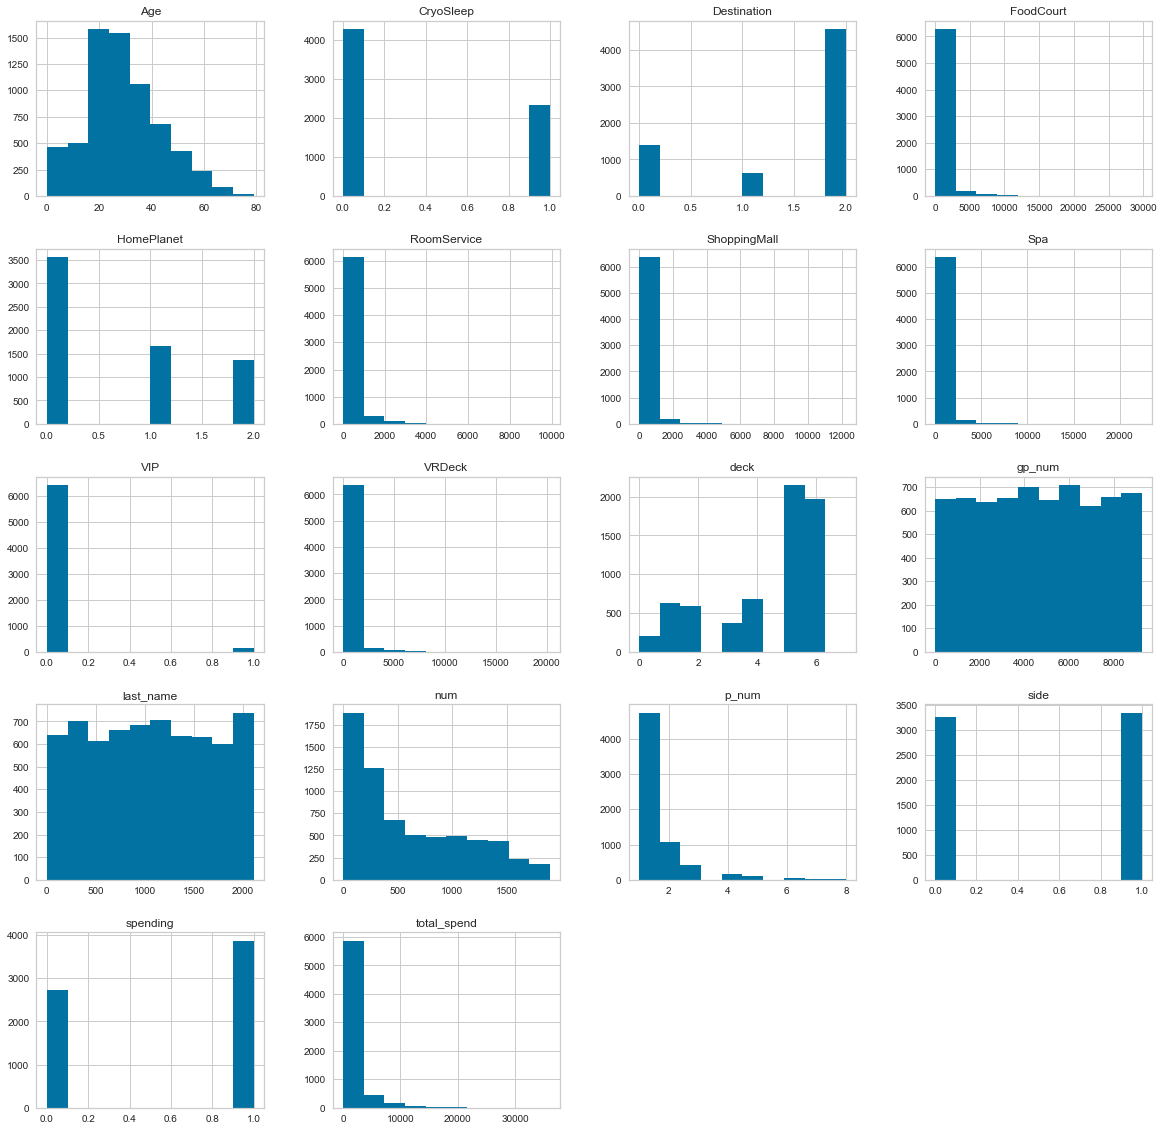

In [36]:
#Check the distirbution of the features 
X_St.hist(figsize=(20,20))#Second tiral

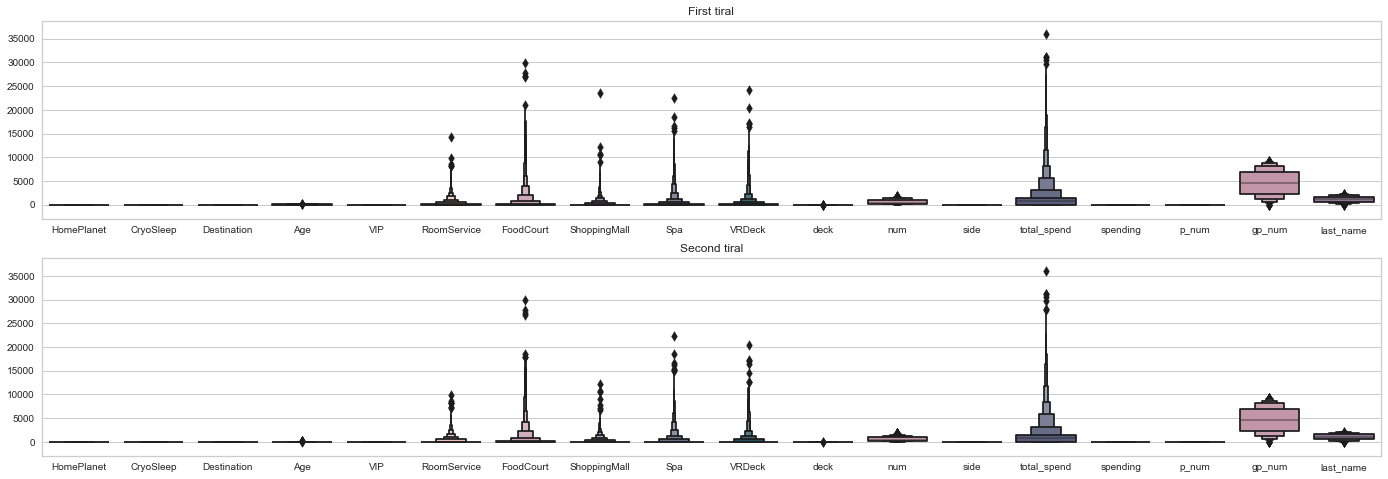

In [37]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(24, 8))
shades =["#f7b2b0","#c98ea6","#8f7198","#50587f", "#003f5c"]
sns.boxenplot(data = X_Ft,palette = shades, ax = ax[0])
ax[0].set_title('First tiral')

sns.boxenplot(data = X_St,palette = shades, ax = ax[1])
ax[1].set_title('Second tiral')
plt.show()

We can see the data range is too large, so we shall scale them into similar scale

##### Scaling

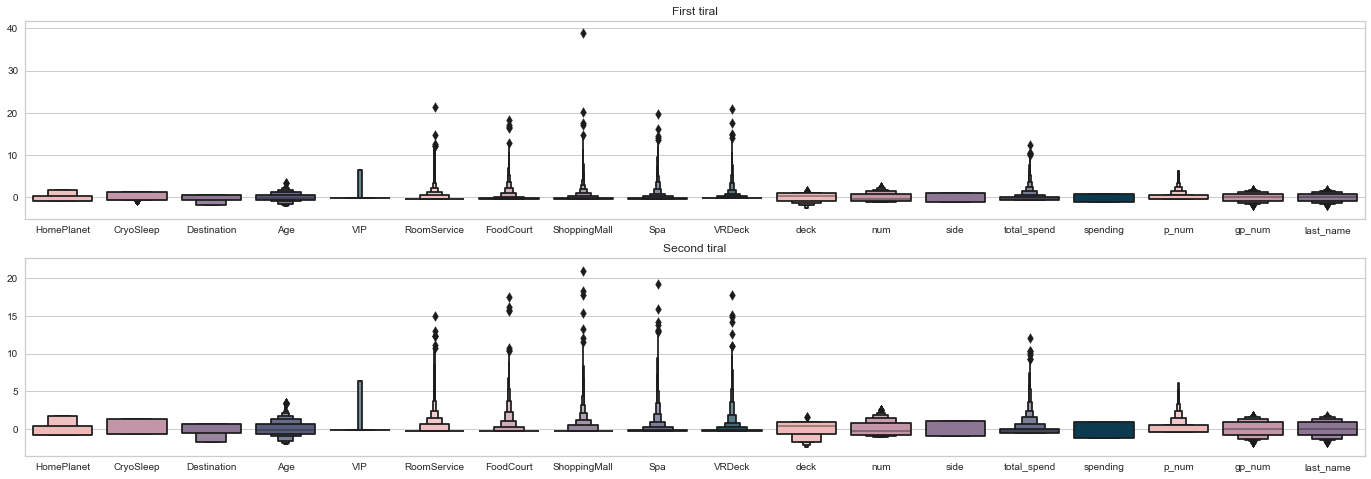

In [38]:
#Looking at the Standard scaled features
s_scaler = StandardScaler()
scal_x_Ft = s_scaler.fit_transform(X_Ft)
col_names_Ft = list(X_Ft.columns)
scal_df_Ft = pd.DataFrame(scal_x_Ft, columns=col_names_Ft)

scal_x_St = s_scaler.fit_transform(X_St)
col_names_St = list(X_St.columns)
scal_df_St = pd.DataFrame(scal_x_St, columns=col_names_St) 

#Plot the result
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(24, 8))
shades =["#f7b2b0","#c98ea6","#8f7198","#50587f", "#003f5c"]
sns.boxenplot(data = scal_df_Ft,palette = shades,ax = ax[0])
ax[0].set_title('First tiral')

sns.boxenplot(data = scal_df_St,palette = shades,ax = ax[1])
ax[1].set_title('Second tiral')
plt.show()

The above results seems not good as it is some negative value

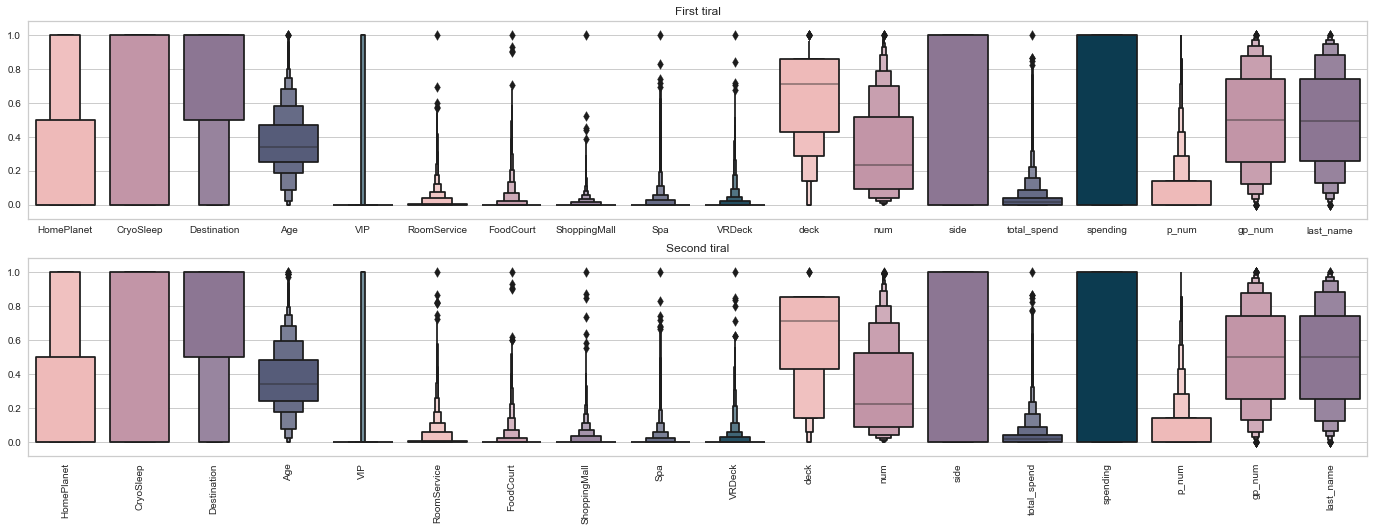

In [39]:
#Looking at the MinMax scaled features
scale = MinMaxScaler(feature_range=(0, 1))
mm_x_Ft =scale.fit_transform(X_Ft)
mm_df_Ft = pd.DataFrame(mm_x_Ft, columns=col_names_Ft)

mm_x_St =scale.fit_transform(X_St)
mm_df_St = pd.DataFrame(mm_x_St, columns=col_names_St) 

#Plot the result
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(24, 8))
shades =["#f7b2b0","#c98ea6","#8f7198","#50587f", "#003f5c"]
sns.boxenplot(data = mm_df_Ft,palette = shades,ax = ax[0])
ax[0].set_title('First tiral')

sns.boxenplot(data = mm_df_St,palette = shades,ax = ax[1])
ax[1].set_title('Second tiral')

plt.xticks(rotation=90)
plt.show()

It seems good as the large number features scaled into 0-1, its distribution is not change, but the 0/1 one hot feature weight should be considered more by the model now

# (2) Modeling

### First tiral data

Split the dataset into training and testing data

In [41]:

X_train_Ft, X_test_Ft, y_train_Ft ,y_test_Ft = train_test_split(mm_x_Ft,y_Ft,test_size=0.3,random_state=42,shuffle=True,stratify=y_Ft)

In [42]:
train_df_Ft = pd.DataFrame(data=X_train_Ft,columns=col_names)
train_df_Ft["Transported"]=list(y_train_Ft)
train_df_Ft.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,total_spend,spending,p_num,gp_num,last_name,Transported
0,0.0,1.0,1.0,0.354430,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.857143,0.312038,1.0,0.000000,0.0,0.0,0.393469,0.343863,0
1,0.5,0.0,0.0,0.405063,0.0,0.0,0.072250,0.0,0.430873,0.035594,0.285714,0.167371,1.0,0.352016,1.0,0.0,0.910443,0.739170,0
2,0.5,0.0,1.0,0.392405,0.0,0.0,0.066515,0.0,0.007676,0.002155,0.285714,0.036959,1.0,0.061328,1.0,0.0,0.201530,0.857401,1


In [43]:
test_df_Ft = pd.DataFrame(data=X_test_Ft,columns=col_names)
test_df_Ft["Transported"]=list(y_test_Ft)
test_df_Ft.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,deck,num,side,total_spend,spending,p_num,gp_num,last_name,Transported
0,0.0,0.0,1.0,0.227848,0.0,0.0,0.009962,0.000000,0.026241,0.000953,0.857143,0.693770,0.0,0.025231,1.0,0.0,0.876819,0.316787,0
1,0.0,0.0,1.0,0.177215,0.0,0.0,0.000000,0.032607,0.000000,0.000000,0.714286,0.786695,0.0,0.021285,1.0,0.0,0.774868,0.135379,0
2,1.0,1.0,1.0,0.544304,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.571429,0.229673,0.0,0.000000,0.0,0.0,0.736717,0.158394,1


We are going to use pycaret whcih is a python package help to applied auto ML to help ous seleted best ML model.

In [44]:
classification_setup = classification.setup(data= train_df_Ft, target='Transported')


,Description,Value
0,session_id,3067
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6085, 19)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [46]:
classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8047,0.8815,0.7639,0.8342,0.7970,0.6095,0.6123,0.2820
gbc,Gradient Boosting Classifier,0.8007,0.8895,0.8185,0.7924,0.8050,0.6012,0.6020,0.2630
rf,Random Forest Classifier,0.7969,0.8854,0.7695,0.8166,0.7918,0.5940,0.5956,0.3040
lightgbm,Light Gradient Boosting Machine,0.7967,0.8905,0.7975,0.7985,0.7976,0.5933,0.5939,0.2200
xgboost,Extreme Gradient Boosting,0.7906,0.8825,0.7812,0.7983,0.7894,0.5812,0.5817,0.3090
ada,Ada Boost Classifier,0.7875,0.8761,0.8232,0.7706,0.7958,0.5748,0.5764,0.0900
lda,Linear Discriminant Analysis,0.7760,0.8594,0.7490,0.7945,0.7707,0.5522,0.5535,0.0120
svm,SVM - Linear Kernel,0.7755,0.0000,0.7443,0.7966,0.7692,0.5512,0.5528,0.0130
ridge,Ridge Classifier,0.7718,0.0000,0.7340,0.7968,0.7638,0.5438,0.5459,0.0080
lr,Logistic Regression,0.7692,0.8465,0.7200,0.8015,0.7583,0.5387,0.5419,0.5040


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3067, verbose=0,
                     warm_start=False)

The above result showing that the best model is Extra Trees Classifier with accuracy 0.8047 and precision 0.8342

In [47]:
et_Ft = classification.create_model("et")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7911,0.8685,0.7523,0.8173,0.7835,0.5823,0.5842
1,0.7864,0.8683,0.7196,0.8324,0.7719,0.5730,0.5784
2,0.7934,0.8642,0.7477,0.8247,0.7843,0.5870,0.5896
3,0.8169,0.8881,0.8178,0.8178,0.8178,0.6338,0.6338
4,0.8122,0.8982,0.7897,0.8284,0.8086,0.6245,0.6252
5,0.8122,0.8742,0.7570,0.8526,0.8020,0.6246,0.6286
6,0.7887,0.8726,0.7116,0.8453,0.7727,0.5781,0.5855
7,0.8028,0.8997,0.7674,0.8291,0.7971,0.6059,0.6076
8,0.8146,0.8840,0.7674,0.8505,0.8068,0.6294,0.6325


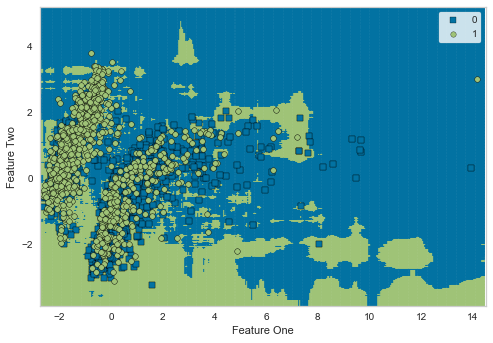

In [ ]:
classification.plot_model(et_Ft, plot = 'boundary')

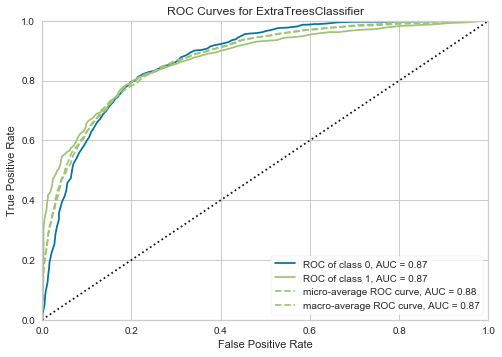

In [ ]:
classification.plot_model(et_Ft, plot = 'auc')

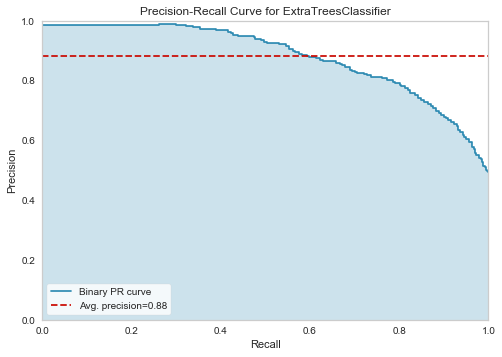

In [ ]:
classification.plot_model(et_Ft, plot = 'pr')

In [ ]:
classification.evaluate_model(et_Ft)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
classification.evaluate_model(et_Ft)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Use the model to conduct prediction using new data(The testing data)

In [48]:
prediction_Ft = classification.predict_model(et_Ft,data=test_df_Ft)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7933,0.8811,0.7471,0.8258,0.7845,0.5869,0.5896


From the above result, we can see that the accuracy is 0.79

We are going to improve the model by some hyperparameter tuning

In [49]:
et_Ft_tuned = classification.tune_model(et_Ft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7746,0.8676,0.7336,0.8010,0.7659,0.5495,0.5514
1,0.7934,0.8803,0.7290,0.8387,0.7800,0.5871,0.5922
2,0.7746,0.8751,0.7103,0.8172,0.7600,0.5496,0.5544
3,0.8052,0.8992,0.7804,0.8227,0.8010,0.6104,0.6112
4,0.7981,0.9073,0.7617,0.8232,0.7913,0.5964,0.5981
5,0.7676,0.8569,0.7243,0.7949,0.7579,0.5354,0.5375
6,0.7840,0.8841,0.7163,0.8324,0.7700,0.5686,0.5743
7,0.8146,0.8933,0.7767,0.8434,0.8087,0.6294,0.6314
8,0.7700,0.8856,0.6744,0.8382,0.7474,0.5407,0.5515


In [50]:
prediction_Ft_tuned = classification.predict_model(et_Ft_tuned,data=test_df_Ft)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7703,0.8803,0.7091,0.8110,0.7566,0.5410,0.5454


The above result showing that after the hyperparameter tuning by PyCaret the performance has decrease.

Therefore, we will keep using the original hyperparameter.

Next, we are trying to use the PCA to reduce the dimension to see if the model performance is better.

### Model using PCA

In [ ]:
classification_setup_PCA = classification.setup(data= train_df_Ft, target='Transported',pca = True,pca_method = "kernel",pca_components = 5)

,Description,Value
0,session_id,7853
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6085, 19)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7450,0.7800,0.6486,0.8071,0.7190,0.4907,0.5007,0.0110
ridge,Ridge Classifier,0.7438,0.0000,0.6622,0.7951,0.7223,0.4882,0.4956,0.0130
lda,Linear Discriminant Analysis,0.7438,0.7781,0.6622,0.7951,0.7223,0.4882,0.4956,0.0100
lr,Logistic Regression,0.7427,0.7784,0.6650,0.7910,0.7222,0.4858,0.4925,0.7810
qda,Quadratic Discriminant Analysis,0.7410,0.7861,0.6426,0.8037,0.7139,0.4827,0.4930,0.0160
gbc,Gradient Boosting Classifier,0.7396,0.7999,0.6393,0.8035,0.7118,0.4799,0.4906,0.2120
svm,SVM - Linear Kernel,0.7384,0.0000,0.6440,0.7985,0.7124,0.4775,0.4873,0.0130
ada,Ada Boost Classifier,0.7319,0.7898,0.6743,0.7663,0.7169,0.4641,0.4681,0.0790
lightgbm,Light Gradient Boosting Machine,0.7309,0.7920,0.6551,0.7753,0.7099,0.4623,0.4683,0.4120
rf,Random Forest Classifier,0.7171,0.7842,0.6631,0.7464,0.7018,0.4345,0.4376,0.3500


GaussianNB(priors=None, var_smoothing=1e-09)

The result showing that using PCA do not help improving the accuracy.

One of the possible reason is that there do not have high correlated variable.

### Stacking

Next, we are going to use stacking to see if the model performance improve

In [52]:
#classification_setup = classification.setup(data= train_df_Ft, target='Transported')
lr = classification.create_model('lr', fold = 5)
knn = classification.create_model('knn', fold = 5)
nb = classification.create_model('nb', fold = 5)
dt = classification.create_model('dt', fold = 5)
svm = classification.create_model('svm', fold = 5)
rbfsvm = classification.create_model('rbfsvm', fold = 5)
gpc = classification.create_model('gpc', fold = 5)
mlp = classification.create_model('mlp', fold = 5)
ridge = classification.create_model('ridge', fold = 5)
rf = classification.create_model('rf', fold = 5)
qda = classification.create_model('qda', fold = 5)
ada = classification.create_model('ada', fold = 5)
lda = classification.create_model('lda', fold = 5)
gbc = classification.create_model('gbc', fold = 5)
et = classification.create_model('et', fold = 5)
xgboost = classification.create_model('xgboost', fold = 5)
lightgbm = classification.create_model('lightgbm', fold = 5)


stacker_all = classification.stack_models(estimator_list = [lr,knn,nb,dt,svm,rbfsvm,gpc,mlp,ridge,rf,qda,ada,lda,gbc,et,xgboost,lightgbm], meta_model = et)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7958,0.8829,0.7827,0.8053,0.7938,0.5916,0.5918
1,0.7946,0.8909,0.7949,0.7967,0.7958,0.5892,0.5892
2,0.8005,0.8934,0.7902,0.8091,0.7995,0.6010,0.6012
3,0.7758,0.8856,0.7716,0.7807,0.7761,0.5517,0.5517
4,0.8167,0.8958,0.7921,0.8350,0.8129,0.6335,0.6343
Mean,0.7967,0.8897,0.7863,0.8053,0.7956,0.5934,0.5936
Std,0.0131,0.0048,0.0084,0.0178,0.0118,0.0262,0.0264


IntProgress(value=0, description='Processing: ', max=6)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:24:25
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Stacking Classifier


,Fold,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


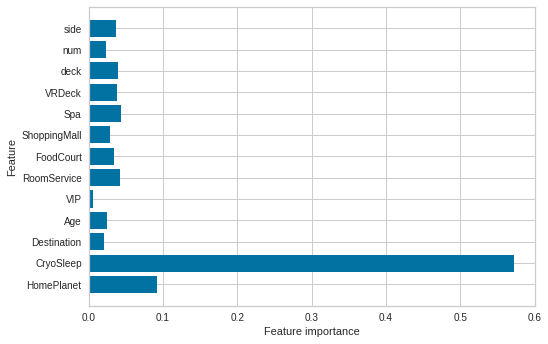

In [ ]:
def plot_feature_importances_cancers(model):
    n_features = mm_x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), list(X.columns))
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_cancer(xgb)